In [1]:
w_python = !which python
if 'home' in w_python[0]:
    resources_prefix = ''
else:
    !pip install watermark unidecode
    !python -m spacy download en_core_web_sm

    from google.colab import drive
    drive.mount('/content/drive')

    resources_prefix = '/content/drive/MyDrive/Machine Learning/Notebooks/0502_NLP - SPAM Detection/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !conda install -y watermark

In [3]:
%load_ext watermark
%watermark

Last updated: 2022-08-06T14:56:08.454626+00:00

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.188+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [4]:
import spacy
import pandas as pd

import os

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np

import re

import random

import unidecode

from html.parser import HTMLParser

import email

import dill

from wordcloud import WordCloud

import string
from string import punctuation

from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, Bidirectional, Conv1D, MaxPooling1D, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.constraints import maxnorm
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.platform import build_info as build
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import nltk  # Natural language toolkit
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')  # stopwords
stopwords = stopwords.words('spanish')

# nlp = spacy.load('es_core_news_lg')  # large
# nlp = spacy.load('es_core_news_sm') # small
# nlp = spacy.load('en_core_web_lg') # large
nlp = spacy.load('en_core_web_sm')  # small

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Resume

https://towardsdatascience.com/spam-detection-with-logistic-regression-23e3709e522

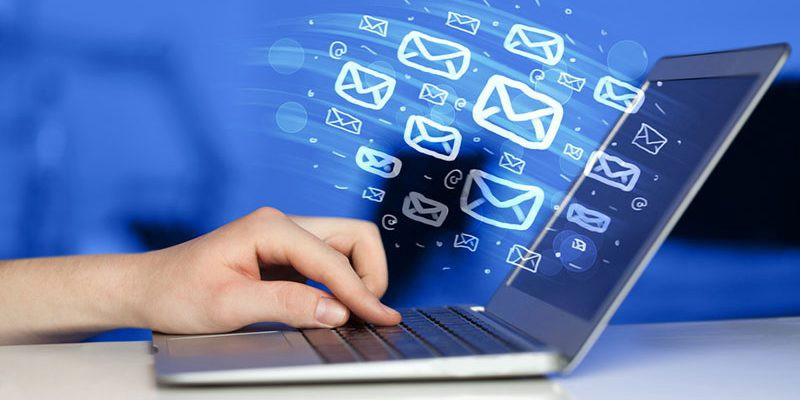

## Data Collection

In [5]:
sns.set_style("whitegrid")

In [6]:
class MLStripper(HTMLParser):
    """Facilita el preprocesamiento de correos electrónicos que poseen código HTML."""

    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return ''.join(self.fed)

In [7]:
class Parser:
    def parse(self, email_path):
        """Parse an email."""

        with open(email_path, errors='ignore') as e:
            msg = email.message_from_file(e)

        return None if not msg else self.__get_email_content(msg)

    def __strip_tags(self, html):
        s = MLStripper()
        s.feed(html)
        return s.get_data()

    def __get_email_content(self, msg):
        """Extract the email content."""

        subject = msg['Subject'] if msg['Subject'] else []
        body = self.__get_email_body(msg.get_payload(), msg.get_content_type())
        content_type = msg.get_content_type()

        # Returning the content of the email
        return {'subject': subject, 'body': body, 'content_type': content_type}

    def __get_email_body(self, payload, content_type):
        """Extract the body of the email."""

        if type(payload) is str and content_type == 'text/plain':
            return payload
        elif type(payload) is str and content_type == 'text/html':
            return self.__strip_tags(payload)
        elif type(payload) is list:
            body = ''

            for p in payload:
                b = self.__get_email_body(p.get_payload(), p.get_content_type())

                if b is None:
                    continue

                body += b

            return body

In [8]:
inmail = open(f"{resources_prefix}_resources/mails/inmail.1").read()
print(inmail)

From RickyAmes@aol.com  Sun Apr  8 13:07:32 2007
Return-Path: <RickyAmes@aol.com>
Received: from 129.97.78.23 ([211.202.101.74])
	by speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;
	Sun, 8 Apr 2007 13:07:21 -0400
Received: from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100
Message-ID: <WYADCKPDFWWTWTXNFVUE@yahoo.com>
From: "Tomas Jacobs" <RickyAmes@aol.com>
Reply-To: "Tomas Jacobs" <RickyAmes@aol.com>
To: the00@speedy.uwaterloo.ca
Subject: Generic Cialis, branded quality@ 
Date: Sun, 08 Apr 2007 21:00:48 +0300
X-Mailer: Microsoft Outlook Express 6.00.2600.0000
MIME-Version: 1.0
Content-Type: multipart/alternative;
	boundary="--8896484051606557286"
X-Priority: 3
X-MSMail-Priority: Normal
Status: RO
Content-Length: 988
Lines: 24

----8896484051606557286
Content-Type: text/html;
Content-Transfer-Encoding: 7Bit

<html>
<body bgcolor="#ffffff">
<div style="border-color: #00FFFF; border-right-width: 0px; border-bottom-width: 0px; margin-bottom: 0px;" align="

In [9]:
p = Parser()
p.parse(f"{resources_prefix}_resources/mails/inmail.1")

{'body': '\n\n\n\n\n\n\nDo you feel the pressure to perform and not rising to the occasion??\n\n\n\n\n\nTry Viagra.....\nyour anxiety will be a thing of the past and you will\nbe back to your old self.\n\n\n',
 'content_type': 'multipart/alternative',
 'subject': 'Generic Cialis, branded quality@ '}

In [10]:
index_list = []

for ix in open(f"{resources_prefix}_resources/indexs").readlines():
    ls = ix.split(" ")
    index_list.append({'target': ls[0], 'path': f'{resources_prefix}_resources/mails/{ls[1][:-1]}'})

index_list[:10]

[{'path': '/content/drive/MyDrive/Machine Learning/Notebooks/0502_NLP - SPAM Detection/_resources/mails/inmail.1',
  'target': 'spam'},
 {'path': '/content/drive/MyDrive/Machine Learning/Notebooks/0502_NLP - SPAM Detection/_resources/mails/inmail.2',
  'target': 'ham'},
 {'path': '/content/drive/MyDrive/Machine Learning/Notebooks/0502_NLP - SPAM Detection/_resources/mails/inmail.3',
  'target': 'spam'},
 {'path': '/content/drive/MyDrive/Machine Learning/Notebooks/0502_NLP - SPAM Detection/_resources/mails/inmail.4',
  'target': 'spam'},
 {'path': '/content/drive/MyDrive/Machine Learning/Notebooks/0502_NLP - SPAM Detection/_resources/mails/inmail.5',
  'target': 'spam'},
 {'path': '/content/drive/MyDrive/Machine Learning/Notebooks/0502_NLP - SPAM Detection/_resources/mails/inmail.6',
  'target': 'spam'},
 {'path': '/content/drive/MyDrive/Machine Learning/Notebooks/0502_NLP - SPAM Detection/_resources/mails/inmail.7',
  'target': 'spam'},
 {'path': '/content/drive/MyDrive/Machine Learnin

In [11]:
def parse_mail(index_list):
    mail_list = []
    i = 0
    total = len(index_list)

    for index in index_list:
        parse = p.parse(index['path'])
        mail_list.append(f'{parse["subject"]} {parse["body"]}')

        i = i+1
        print("\rParsing {0} of {1}".format(i, total), end='')

    return mail_list


try:
    pkl_filename = f'{resources_prefix}_resources/mail_parsed.pkl'

    with open(pkl_filename, 'rb') as file:
        mail_list = pickle.load(file)
except:
    mail_list = parse_mail(index_list)

    with open(pkl_filename, 'wb') as file:
        pickle.dump(mail_list, file)
finally:
    display(mail_list[:3])

['Generic Cialis, branded quality@  \n\n\n\n\n\n\nDo you feel the pressure to perform and not rising to the occasion??\n\n\n\n\n\nTry Viagra.....\nyour anxiety will be a thing of the past and you will\nbe back to your old self.\n\n\n',
 'Typo in /debian/README Hi, i\'ve just updated from the gulus and I check on other mirrors.\nIt seems there is a little typo in /debian/README file\n\nExample:\nhttp://gulus.usherbrooke.ca/debian/README\nftp://ftp.fr.debian.org/debian/README\n\n"Testing, or lenny.  Access this release through dists/testing.  The\ncurrent tested development snapshot is named etch.  Packages which\nhave been tested in unstable and passed automated tests propogate to\nthis release."\n\netch should be replace by lenny like in the README.html\n\n\n\n-- \nYan Morin\nConsultant en logiciel libre\nyan.morin@savoirfairelinux.com\n514-994-1556\n\n\n-- \nTo UNSUBSCRIBE, email to debian-mirrors-REQUEST@lists.debian.org\nwith a subject of "unsubscribe". Trouble? Contact listmaster@l

In [12]:
target = [index['target'] for index in index_list]
target[:10]

['spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham']

In [13]:
df = pd.DataFrame(data={'mail': mail_list, 'type': target})
del mail_list
df.head(10)

,mail,type
0,"Generic Cialis, branded quality@ \n\n\n\n\n\n...",spam
1,"Typo in /debian/README Hi, i've just updated f...",ham
2,authentic viagra Mega authenticV I A G R A ...,spam
3,"Nice talking with ya \nHey Billy, \n\nit was r...",spam
4,or trembling; stomach cramps; trouble in sleep...,spam
5,Which is duty \nthe program and the creative a...,spam
6,For Theorize Glad to see you!Look at the assor...,spam
7,Theorize get inside for local esc0rts who do i...,spam
8,Losing Weight Quickly HoodiaLife - Start Los...,spam
9,[R] Confidence-Intervals.... help... \nHi...\n...,ham


## Data Wrangling

In [14]:
df.dtypes   # Tipos de variables

mail    object
type    object
dtype: object

Feature and dependent column.

In [15]:
feature_column = 'mail'
target_column = 'target'

For best model performance, dependent classes should start at 0 and not 1.

In [16]:
df.loc[(df['type'] == 'ham'), target_column] = 0
df.loc[(df['type'] == 'spam'), target_column] = 1

df[target_column] = df[target_column].astype('category')

df.head(10)

,mail,type,target
0,"Generic Cialis, branded quality@ \n\n\n\n\n\n...",spam,1.0
1,"Typo in /debian/README Hi, i've just updated f...",ham,0.0
2,authentic viagra Mega authenticV I A G R A ...,spam,1.0
3,"Nice talking with ya \nHey Billy, \n\nit was r...",spam,1.0
4,or trembling; stomach cramps; trouble in sleep...,spam,1.0
5,Which is duty \nthe program and the creative a...,spam,1.0
6,For Theorize Glad to see you!Look at the assor...,spam,1.0
7,Theorize get inside for local esc0rts who do i...,spam,1.0
8,Losing Weight Quickly HoodiaLife - Start Los...,spam,1.0
9,[R] Confidence-Intervals.... help... \nHi...\n...,ham,0.0


In [17]:
target_names = df.type.unique()
target_names

array(['spam', 'ham'], dtype=object)

In [18]:
df[target_column].unique()

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


[1.0, 0.0]
Categories (2, float64): [0.0, 1.0]

## Data Cleaning

Completely empty columns are removed.

In [19]:
df.dropna(axis=1, how='all', inplace=True)

Completely empty rows are removed.

In [20]:
df.dropna(axis=0, how='all', inplace=True)

# In case you want to delete the row if any of its values is missing, use 'any' in the 'how' parameter
# Use subset['col1', 'col2'] if you want to apply to some columns only.

## Data Visualization

Media de palabras: 2264.87
Desviación estandard: 4938.47


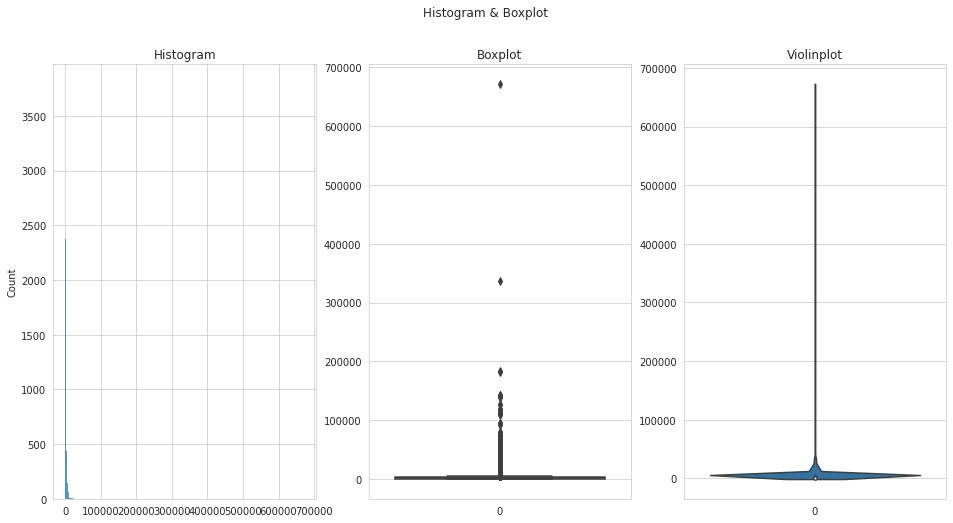

In [21]:
def summarize_data_lenght(data):
    cc = [len(x) for x in data]

    print(f'Media de palabras: {round(np.mean(cc), 2)}')
    print(f'Desviación estandard: {round(np.std(cc), 2)}')

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
    fig.suptitle('Histogram & Boxplot')

    sns.histplot(data=cc, ax=axes[0])
    axes[0].set_title('Histogram')

    sns.boxplot(data=cc, ax=axes[1])
    axes[1].set_title('Boxplot')

    sns.violinplot(data=cc, ax=axes[2])
    axes[2].set_title('Violinplot')


summarize_data_lenght(data=df[feature_column])

## Machine Learning

### Data Selection

In [22]:
features_data = df[feature_column]
target_data = df[target_column]

features_data[:10]

0    Generic Cialis, branded quality@  \n\n\n\n\n\n...
1    Typo in /debian/README Hi, i've just updated f...
2    authentic viagra Mega  authenticV I A G R A   ...
3    Nice talking with ya \nHey Billy, \n\nit was r...
4    or trembling; stomach cramps; trouble in sleep...
5    Which is duty \nthe program and the creative a...
6    For Theorize Glad to see you!Look at the assor...
7    Theorize get inside for local esc0rts who do i...
8    Losing Weight Quickly   HoodiaLife - Start Los...
9    [R] Confidence-Intervals.... help... \nHi...\n...
Name: mail, dtype: object

### Standardization

Cleaning data.

In [23]:
class MyStandardizationTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        array = X.values

        corpus = []

        for i in range(0, len(array)):
            doc = nlp(array[i])

            # lemmatizer and lower and strip and is_alpha and no is_stop (spacy)
            tokens = [tok.lemma_.lower().strip() for tok in doc if tok.is_alpha == True and tok.is_stop == False]

            # stopwords and punctuation (nltk)
            tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuation]

            tokens = ' '.join(tokens)

            corpus.append(tokens)

            print("\rTransforming data: {0} of {1}".format(i+1, len(array)), end='')

        corpus = pd.Series(data=corpus)

        return corpus

Se cargan los datos ya limpios (si existen), caso contrario ejecutar el algoritmo anterior.

0    generic cialis brand feel pressure perform ris...
1    typo readme hi update gulus check mirror littl...
2    authentic viagra mega authenticv g r discount ...
dtype: object

Media de palabras: 1018.9
Desviación estandard: 1844.1


None

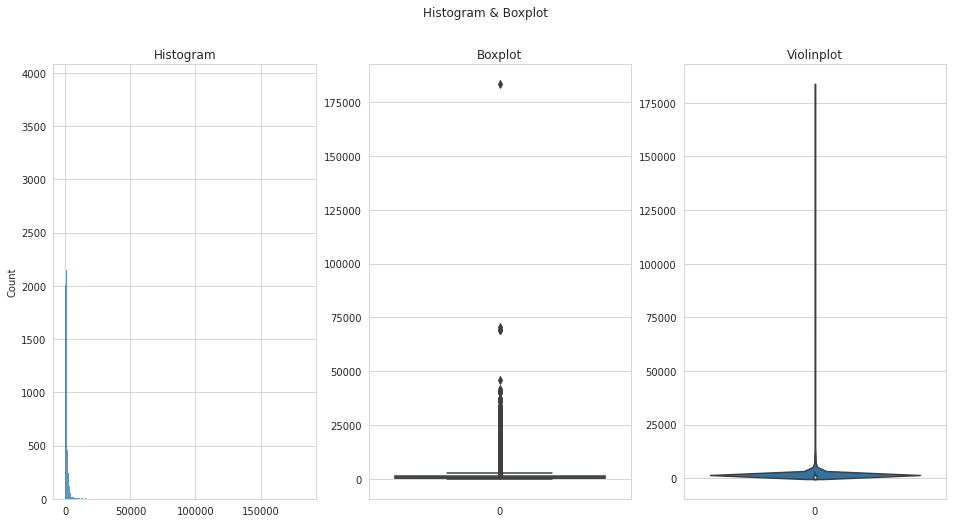

In [24]:
try:
    pkl_filename = f'{resources_prefix}_resources/corpus_cleaned.pkl'

    with open(pkl_filename, 'rb') as file:
        corpus = pickle.load(file)
except:
    standardization = MyStandardizationTransformer()
    corpus = standardization.fit_transform(features_data)

    with open(pkl_filename, 'wb') as file:
        pickle.dump(corpus, file)
finally:
    display(corpus[:3])
    display(summarize_data_lenght(data=corpus))

Se eliminan los elementos vacíos.

In [25]:
empty_indexs = [i for i, text in enumerate(corpus) if text == '']

corpus = corpus.drop(index=empty_indexs).values
target_data = target_data.drop(index=empty_indexs).values

len(corpus), len(target_data)

(74821, 74821)

### Vectorizer

#### CountVectorizer

https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/

In [26]:
# CountVectorizer acepta parámetros para realizar la limpieza de los datos realizada manualmente en la sesión anterior.
# La limpieza manual es mejor porque se puede limpiar otros detalles más adelante.
# Máxima cantidad de columnas. Se seleccionarán las palabras que más frecuencias tengan.
# Por ejemplo, si aparece un nombre o apellido es probable que solo tenga una frecuencia, esa columna no es relevante.
# TfidfVectorizer es mejor que CountVectorizer porque no solo analiza la cantidad de repeticiones de una palabra,
# sino la importancia de su aparición.
count_vectorizer = CountVectorizer(analyzer='word', max_features=None)  # Palabras con más importancia (probar varias opciones)

# Se obtiene la matriz dispersa: en las filas las valoraciones y en las columnas las frecuencias
count_vector = count_vectorizer.fit_transform(corpus)

Vocabulary.

In [27]:
count_vect_vocabulary = count_vectorizer.vocabulary_
display(list(count_vect_vocabulary.items())[:10])

del count_vect_vocabulary

[('generic', 61050),
 ('cialis', 27318),
 ('brand', 19789),
 ('feel', 54537),
 ('pressure', 127581),
 ('perform', 120574),
 ('rise', 139425),
 ('occasion', 111445),
 ('try', 168751),
 ('viagra', 176791)]

Vectors.

In [28]:
display(count_vector.shape)
display(count_vector)

(74821, 191656)

<74821x191656 sparse matrix of type '<class 'numpy.int64'>'
	with 6076551 stored elements in Compressed Sparse Row format>

Se obtienen los vectores.

In [29]:
print(corpus[0])
count_vectorizer_df = pd.DataFrame(data=count_vectorizer.transform([corpus[0]]).toarray(), columns=count_vectorizer.get_feature_names_out())

# Se Seleccionan solamente las columnas (palabras) del texto, caso contrario se observarían muchos 0s.
display(count_vectorizer_df[corpus[0].split()])

del count_vectorizer_df

generic cialis brand feel pressure perform rise occasion try viagra anxiety thing past old self


,generic,cialis,brand,feel,pressure,perform,rise,occasion,try,viagra,anxiety,thing,past,old,self
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


#### TfidfVectorizer

In [30]:
# TfidfVectorizer acepta parámetros para realizar la limpieza de los datos realizada manualmente en la sesión anterior.
# La limpieza manual es mejor porque se puede limpiar otros detalles más adelante.
# Máxima cantidad de columnas. Se seleccionarán las palabras que más frecuencias tengan.
# Por ejemplo, si aparece un nombre o apellido es probable que solo tenga una frecuencia, esa columna no es relevante.
tfidf_vectorizer = TfidfVectorizer(analyzer='word', max_features=None)  # Palabras con más importancia (probar varias opciones)

# Se obtiene la matriz dispersa: en las filas las valoraciones y en las columnas las frecuencias
# vector será nuestra variable independiente
# Se convierte a array porque es una matriz sparse
tfidf_vector = tfidf_vectorizer.fit_transform(corpus)

Vocabulary.

In [32]:
tfidf_vocabulary = tfidf_vectorizer.vocabulary_
display(list(tfidf_vocabulary.items())[:10])

del tfidf_vocabulary

[('generic', 61050),
 ('cialis', 27318),
 ('brand', 19789),
 ('feel', 54537),
 ('pressure', 127581),
 ('perform', 120574),
 ('rise', 139425),
 ('occasion', 111445),
 ('try', 168751),
 ('viagra', 176791)]

Vectors.

In [33]:
display(tfidf_vector.shape)
display(tfidf_vector)

(74821, 191656)

<74821x191656 sparse matrix of type '<class 'numpy.float64'>'
	with 6076551 stored elements in Compressed Sparse Row format>

Se obtienen los vectores.

In [34]:
print(corpus[0])
tfidf_vectorizer_df = pd.DataFrame(data=tfidf_vectorizer.transform([corpus[0]]).toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Se Seleccionan solamente las columnas (palabras) del texto, caso contrario se observarían muchos 0s.
display(tfidf_vectorizer_df[corpus[0].split()])

del tfidf_vectorizer_df

generic cialis brand feel pressure perform rise occasion try viagra anxiety thing past old self


,generic,cialis,brand,feel,pressure,perform,rise,occasion,try,viagra,anxiety,thing,past,old,self
0,0.233018,0.226174,0.273498,0.218749,0.293331,0.288142,0.256326,0.376303,0.173628,0.204041,0.370681,0.193921,0.266403,0.20842,0.185261


### Cross Validation

Confusion Matrix.

In [35]:
def show_confusion_matrix(estimator, X, y):
    titles_options = {"Confusion Matrix": None, "Normalized Confusion Matrix": 'true'}

    f, axes = plt.subplots(1, len(titles_options), figsize=(12, 6), sharey='row')

    for i, (title, normalize) in enumerate(titles_options.items()):
        disp = ConfusionMatrixDisplay.from_estimator(estimator, X, y, display_labels=target_names, cmap=plt.cm.Blues, normalize=normalize, ax=axes[i])
        disp.ax_.set_title(title)

    plt.show()

In [36]:
def my_cross_validate(estimator, X, y, show_msg):
    scores = cross_validate(estimator=estimator, X=X, y=y, scoring='accuracy', cv=3, n_jobs=-1, return_train_score=True)

    estimator.fit(X, y)  # To return the already adjusted estimator.

    score = round(scores['test_score'].mean(), 4)

    if show_msg == True:
        print(f'The model has a degree of accuracy of {score * 100}%.')
        show_confusion_matrix(estimator, X, y)

    return estimator, score

In [37]:
def my_grid_search_cv(estimator, X, y, param_grid, show_msg):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, return_train_score=True)
    grid_search.fit(X, y)
    estimator = grid_search.best_estimator_

    score = round(grid_search.best_score_, 4)

    if show_msg == True:
        print(f'The model has a degree of accuracy of {score * 100}%.')
        show_confusion_matrix(estimator, X, y)

    return estimator, score

The dataframe for the evaluation results of each algorithm is defined.

In [38]:
results = pd.DataFrame(columns=['MODEL', 'ACCURACY', 'ESTIMATOR'])

### Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


The model has a degree of accuracy of 98.58%.


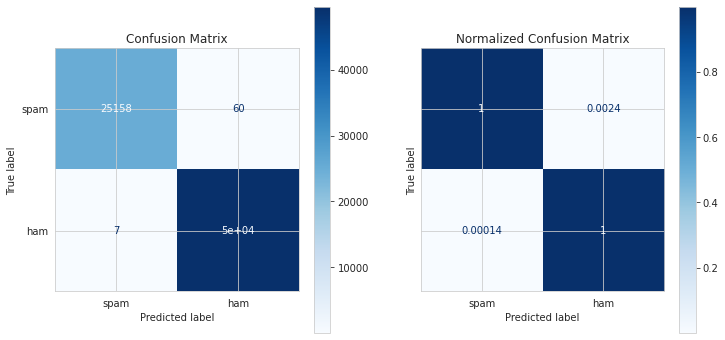

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9858,"(CountVectorizer(), LogisticRegression())"


The model has a degree of accuracy of 98.44000000000001%.


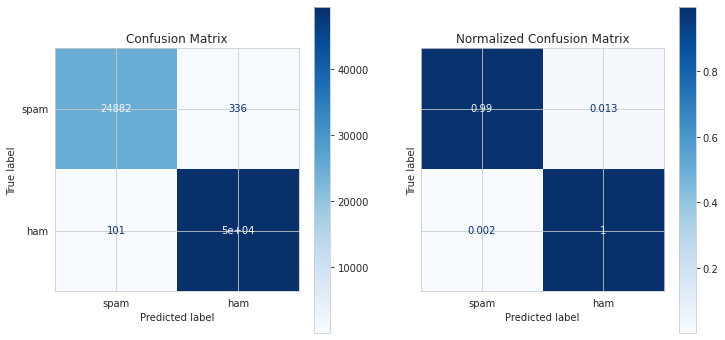

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9858,"(CountVectorizer(), LogisticRegression())"
1,logistic,0.9844,"(TfidfVectorizer(), LogisticRegression())"


In [39]:
def my_logistic_regression(results, features_data, target_data, vectorizer, show_msg=False):
    input = [('vectorizer', vectorizer(analyzer='word', max_features=None)), ('model', LogisticRegression())]

    estimator, score = my_cross_validate(estimator=Pipeline(steps=input), X=features_data, y=target_data, show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['logistic'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, clf = my_logistic_regression(results, corpus, target_data, CountVectorizer, True)
display(results)

results, clf = my_logistic_regression(results, corpus, target_data, TfidfVectorizer, True)
display(results)

### Naive Bayes

#### Multinomial Naive Bayes

The model has a degree of accuracy of 94.41000000000001%.


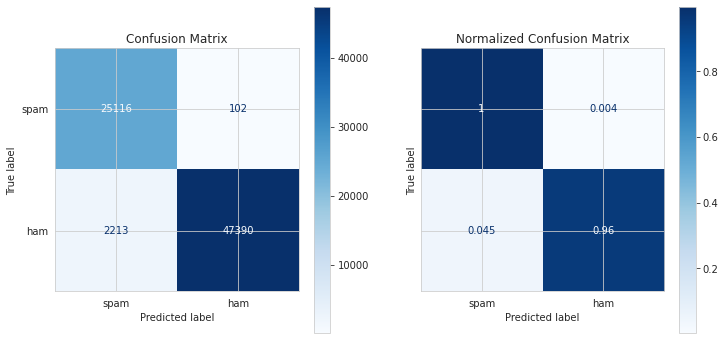

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9858,"(CountVectorizer(), LogisticRegression())"
1,logistic,0.9844,"(TfidfVectorizer(), LogisticRegression())"
2,multinomial_nb,0.9441,"(CountVectorizer(), MultinomialNB())"


The model has a degree of accuracy of 97.31%.


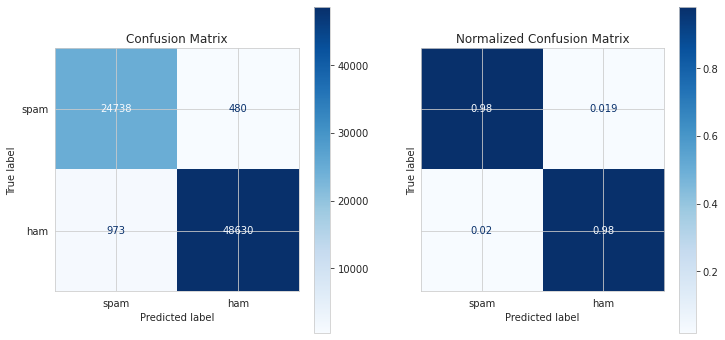

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9858,"(CountVectorizer(), LogisticRegression())"
1,logistic,0.9844,"(TfidfVectorizer(), LogisticRegression())"
2,multinomial_nb,0.9441,"(CountVectorizer(), MultinomialNB())"
3,multinomial_nb,0.9731,"(TfidfVectorizer(), MultinomialNB())"


In [40]:
def my_multinomial_nb(results, features_data, target_data, vectorizer, show_msg=False):
    input = [('vectorizer', vectorizer(analyzer='word', max_features=None)), ('model', MultinomialNB())]

    estimator, score = my_cross_validate(estimator=Pipeline(steps=input), X=features_data, y=target_data, show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['multinomial_nb'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, clf = my_multinomial_nb(results, corpus, target_data, CountVectorizer, True)
display(results)

results, clf = my_multinomial_nb(results, corpus, target_data, TfidfVectorizer, True)
display(results)

#### Bernoulli Naive Baye

The model has a degree of accuracy of 93.49%.


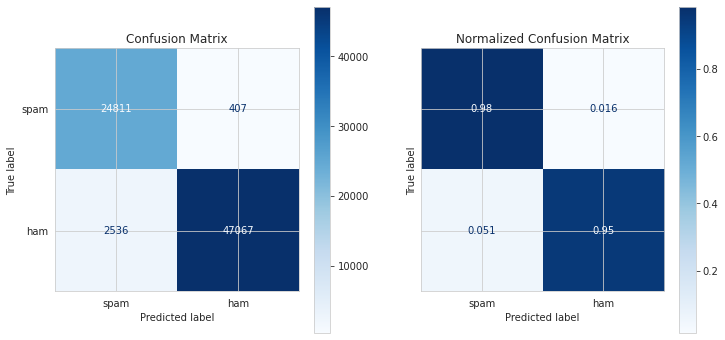

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9858,"(CountVectorizer(), LogisticRegression())"
1,logistic,0.9844,"(TfidfVectorizer(), LogisticRegression())"
2,multinomial_nb,0.9441,"(CountVectorizer(), MultinomialNB())"
3,multinomial_nb,0.9731,"(TfidfVectorizer(), MultinomialNB())"
4,bernoulli_nb,0.9349,"(CountVectorizer(), BernoulliNB())"


The model has a degree of accuracy of 93.49%.


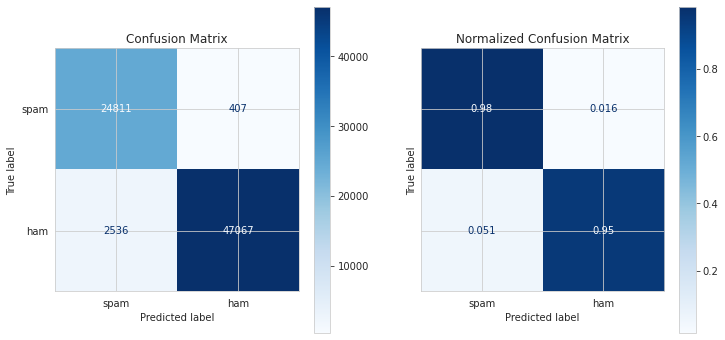

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9858,"(CountVectorizer(), LogisticRegression())"
1,logistic,0.9844,"(TfidfVectorizer(), LogisticRegression())"
2,multinomial_nb,0.9441,"(CountVectorizer(), MultinomialNB())"
3,multinomial_nb,0.9731,"(TfidfVectorizer(), MultinomialNB())"
4,bernoulli_nb,0.9349,"(CountVectorizer(), BernoulliNB())"
5,bernoulli_nb,0.9349,"(TfidfVectorizer(), BernoulliNB())"


In [41]:
def my_bernoulli_nb(results, features_data, target_data, vectorizer, show_msg=False):
    input = [('vectorizer', vectorizer(analyzer='word', max_features=None)), ('model', BernoulliNB())]

    estimator, score = my_cross_validate(estimator=Pipeline(steps=input), X=features_data, y=target_data, show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['bernoulli_nb'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, clf = my_bernoulli_nb(results, corpus, target_data, CountVectorizer, True)
display(results)

results, clf = my_bernoulli_nb(results, corpus, target_data, TfidfVectorizer, True)
display(results)

### Resume

In [42]:
results_sort = results.sort_values(by=['ACCURACY'], ascending=[False])
results_sort

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.9858,"(CountVectorizer(), LogisticRegression())"
1,logistic,0.9844,"(TfidfVectorizer(), LogisticRegression())"
3,multinomial_nb,0.9731,"(TfidfVectorizer(), MultinomialNB())"
2,multinomial_nb,0.9441,"(CountVectorizer(), MultinomialNB())"
4,bernoulli_nb,0.9349,"(CountVectorizer(), BernoulliNB())"
5,bernoulli_nb,0.9349,"(TfidfVectorizer(), BernoulliNB())"


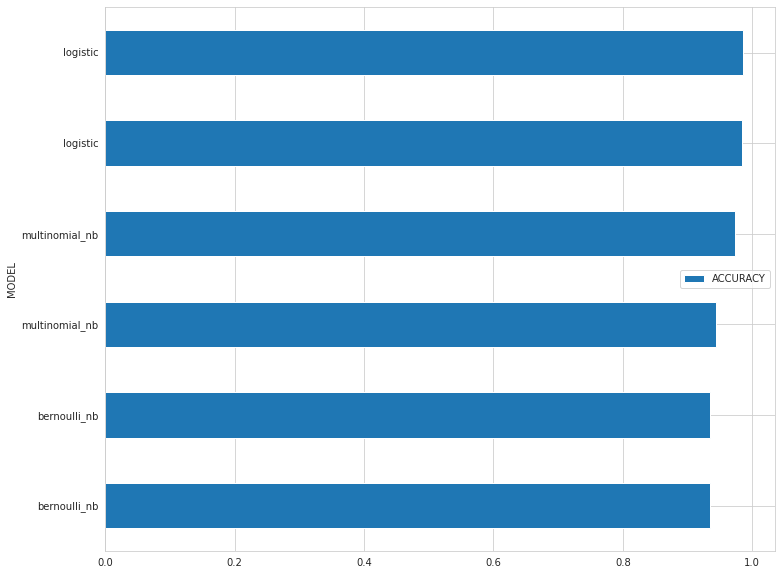

In [43]:
plt.rc("figure", figsize=(12, 10))
results_sort[::-1].set_index('MODEL').plot.barh(rot=0)

In [44]:
print(f'Best tentative algorithm "{results_sort.iloc[0].MODEL}" with ACCURACY={results_sort.iloc[0].ACCURACY}".')

Best tentative algorithm "logistic" with ACCURACY=0.9858".


### Export

In [45]:
best_estimator = results_sort.iloc[0].ESTIMATOR

Save to file.

In [46]:
pkl_filename = f'{resources_prefix}_resources/best_estimator.pkl'

with open(pkl_filename, 'wb') as file:
    pickle.dump(best_estimator, file)

Load from file.

In [47]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [48]:
pickle_model

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('model', LogisticRegression())])

## Deep Learning

Cuda version.

In [49]:
print(f"Tensorflow version: {tf.__version__}")
print(f"Cuda version: {build.build_info['cuda_version']}")
print(f"Cudnn version: {build.build_info['cudnn_version']}")

Tensorflow version: 2.8.2
Cuda version: 11.1
Cudnn version: 8


**Enable GPU**

- The environment must be created with a version of Python compatible with the operation of Tensorflow and its use of the GPU (https://www.tensorflow.org/install/pip#virtual-environment-install).
- Before installing tensorflow-gpu you must install CUDA Toolkit and cuDNN from official NVIDIA site.
- Anaconda must be restarted after installing tensorflow-gpu.

In [50]:
# !conda install -y tensorflow-gpu keras-gpu

In [51]:
if len(tf.config.list_physical_devices('GPU')) == 0:
    raise SystemExit("Restart Anaconda to activate the GPU.")
else:
    print('GPU activated.')

GPU activated.


Available hardware.

In [52]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available hardware details.

In [53]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11522293684397718163
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9695000222697871591
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

### Vectorizer

Se debe seleccionar `Tokenizer`[1], `TextVectorization`[2] o `spacy`[3].

[1] y [2]: Se genera una capa de incrustación.

[3]: No es necesario generar una capa de incrustación.

In [54]:
# Tokenizer => 'tokenizer'
# TextVectorization => 'text_vectorization'
# spacy => 'spacy'

vectorizer = 'spacy'

Se puede restringir la cantidad de muestras, el número de palabras del diccionario y el máximo de palabras tomadas por cada observación.

In [55]:
# cantidad de muestras
# None: all
print('Total de muestras:', len(corpus))
max_samples = 9000

# número de palabras del diccionario
# None: all
max_tokens = 9000

# máximo de palabras tomadas por cada observación
# max_len: all
max_len = max([len(sentence.split(sep=' ')) for sentence in corpus])
print('Máxima cantidad de palabras por muestras:', max_len)
max_len = 1000

Total de muestras: 74821
Máxima cantidad de palabras por muestras: 33895


In [56]:
if max_samples != None:
    print('Before:', corpus.shape, target_data.shape)

    li = range(0, len(corpus)-1)
    i_rand = random.sample(li, max_samples)

    # Se convierte a series para ejecutar el iloc a partir de un listado de indexs.
    corpus = pd.Series(data=corpus)
    target_data = pd.Series(data=target_data)

    corpus = corpus.iloc[i_rand].values
    target_data = target_data.iloc[i_rand].values

    print('After:', corpus.shape, target_data.shape)

    del i_rand

Before: (74821,) (74821,)
After: (9000,) (9000,)


#### Tokenizer

Se utiliza `Tokenizer` para `normalizar` los datos y que puedan ser utilizado en `Long Short Term Memory Networks (LSTMs)`.

Tokenizer elimina por defecto los signos de puntuación y convierte las mayúsculas en minúsculas.

Para el idioma `Ingles`, son mejores los siguientes parametros:
- filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n'
- lower = False

In [57]:
class MyTokenizer(BaseEstimator, TransformerMixin):
    def fit(self, corpus, y=None):
        self.Tokenizer = Tokenizer(num_words=max_tokens)
        self.Tokenizer.fit_on_texts(corpus)

        return self

    def transform(self, corpus, y=None):
        # Transformando cada texto en una secuencia de números enteros.
        vector = self.Tokenizer.texts_to_sequences(corpus)

        # Rellenando con 0 los valores finales de cada secuencia.
        vector = pad_sequences(sequences=vector, maxlen=max_len, padding='post', truncating='post', value=0.0)

        return vector


if vectorizer == 'tokenizer':
    tokenizer = MyTokenizer()
    features_data_vectorized = tokenizer.fit_transform(corpus)
    display(features_data_vectorized.shape)

In [58]:
if vectorizer == 'tokenizer':
    pkl_filename = f'{resources_prefix}_resources/tokenizer.pkl'

    with open(pkl_filename, 'wb') as file:
        dill.dump(tokenizer, file)

    with open(pkl_filename, 'rb') as file:
        tokenizer = dill.load(file)

Vocabulary

In [59]:
if vectorizer == 'tokenizer':
    tokenizer_vocabulary = tokenizer.Tokenizer.word_index
    display(tokenizer_vocabulary)

Obtener `corpus` a partir de los vectores generados.

In [60]:
if vectorizer == 'tokenizer':
    display('original:')
    display(corpus[0])

    display('generado:')
    display(tokenizer.Tokenizer.sequences_to_texts([features_data_vectorized[0]])[0])

In [61]:
if vectorizer == 'tokenizer':
    first_layer = Embedding(input_dim=len(tokenizer_vocabulary) + 1, output_dim=128, input_length=features_data_vectorized.shape[1])

#### TextVectorization

In [62]:
if vectorizer == 'text_vectorization':
    vectorize_layer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_len)

    # Genera el vocabulario
    vectorize_layer.adapt(corpus)

    features_data_vectorized = vectorize_layer(corpus).numpy()
    display(features_data_vectorized.shape)

Vocabulary

Se debe actualizar a un diccionario para obtener la misma estructura de datos que `Tokenizer`.

In [63]:
if vectorizer == 'text_vectorization':
    vectorize_vocabulary = {word: i for i, word in enumerate(vectorize_layer.get_vocabulary())}
    display(vectorize_vocabulary)

In [64]:
if vectorizer == 'text_vectorization':
    first_layer = Embedding(input_dim=len(vectorize_vocabulary) + 1, output_dim=128, input_length=features_data_vectorized.shape[1])

#### Spacy

En caso que el número de palabras del diccionario se encuentre restringido, es necesario crear un nuevo `corpus` con las palabras más importantes del diccionario. Para el proceso nos ayudamos de `Tokenizer`.

In [65]:
if vectorizer == 'spacy' and max_tokens != None:
    tokenizer = Tokenizer(num_words=max_tokens)
    tokenizer.fit_on_texts(corpus)

    print('All vocabulary:', len(tokenizer.word_index))

    features_data_vectorized = tokenizer.texts_to_sequences(corpus)
    corpus = tokenizer.sequences_to_texts(features_data_vectorized)

    del tokenizer

    # Se eliminan los elementos vacíos.
    empty_indexs = [i for i, text in enumerate(corpus) if text == '']

    # Se convierte a series para ejecutar el drop a partir de un listado de indexs.
    corpus = pd.Series(data=corpus)
    target_data = pd.Series(data=target_data)

    corpus = corpus.drop(index=empty_indexs).values
    target_data = target_data.drop(index=empty_indexs).values

    print(len(corpus), len(target_data))

All vocabulary: 62615
8981 8981


In [66]:
def spacy_vectorizer(corpus, max_len):
    n = len(corpus)
    nlp_len = len(nlp(text='a').vector)
    # Se puede inicilizar en zeros (la memoria crece poco a poco)
    # Si se inicializa en ones, se reserva toda la memoria inmediatamente, 1.0 ocupa más espacio que 0.0
    features_data_vectorized = np.ones(shape=(n, max_len, nlp_len), dtype=np.float32)

    for i in range(0, n):
        doc = nlp(corpus[i])

        vector = [tok.vector for tok in doc][:max_len]
        vector = np.array(object=vector, dtype=np.float32)

        # Se rellenan con ceros cuando la cantidad de palabras de la oración sea menor que el máximo.
        pad_vector = np.zeros(shape=(max_len-vector.shape[0], nlp_len), dtype=np.float32)

        vector = np.concatenate((vector, pad_vector), axis=0)
        
        features_data_vectorized[i] = vector

        print("\r Items {0} of {1}".format(i, n), end='')

    return features_data_vectorized


if vectorizer == 'spacy':
    features_data_vectorized = spacy_vectorizer(corpus, max_len)
    display(features_data_vectorized.shape)

 Items 8980 of 8981

(8981, 1000, 96)

In [67]:
if vectorizer == 'spacy':
    first_layer = Input(shape=features_data_vectorized.shape[1:])

### Keras

In [68]:
# lstm => Long Short Term Memory Networks (LSTM)
# cnn => Convolutional Neural Networks (CNN)

keras_net_type = 'cnn'

`Targets` to `one-hot-encoding`.

In [69]:
target_data[:10]

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Categories (2, float64): [0.0, 1.0]

In [70]:
target_data = target_data.to_numpy()
target_data[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Los problemas de clasificación binaria no necesitan tranformar la variable objetivo.

Los datos de entrenamiento son creados independientemente del `vectorizer` seleccionado.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(features_data_vectorized, target_data, test_size=0.2)
del features_data_vectorized, target_data

In [72]:
earlystop = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)

In [73]:
keras_file_path = f'{resources_prefix}_resources/keras.hdf5'
checkpoint = ModelCheckpoint(filepath=keras_file_path, verbose=1, save_weights_only=True, save_freq='epoch')

In [74]:
if keras_net_type == 'lstm':
    # if error => !conda install -y numpy=1.19

    with tf.device("/GPU:0"):
        # clasificación binaria: activation sigmoid en la ultima capa y binary_crossentropy como loss.
        # clasificación multiclase: activation softmax en la ultima capa y categorical_crossentropy como loss.

        keras_model = Sequential([first_layer,

                                 LSTM(units=100, dropout=0.2, return_sequences=True),

                                 LSTM(units=100, dropout=0.2, return_sequences=True),

                                 LSTM(units=100, dropout=0.2, return_sequences=True),

                                 LSTM(units=100, dropout=0.2, return_sequences=True),

                                 LSTM(units=100, dropout=0.2, return_sequences=False),

                                 Dense(units=100, activation='relu', kernel_constraint=maxnorm(max_value=3)),
                                 Dense(units=100, activation='relu', kernel_constraint=maxnorm(max_value=3)),
                                 Dropout(rate=0.2),

                                 Dense(units=1, activation='sigmoid')])

    #   categorical_crossentropy: Retorna la clase predecida, en la última capa Dense units debe ser 1.
    #   sparse_categorical_crossentropy: Retorna las probabilidades de cada clase, en la última capa Dense units debe ser el número de clases.

        keras_model.compile(optimizer=Adam(learning_rate=0.01),       # optimizer
                            loss='binary_crossentropy',               # función de pérdida o coste
                            metrics=['accuracy'])                     # Métricas para observar la evolución del entrenamiento del modelo (precisión)

        try:
            keras_model.load_weights(filepath=keras_file_path)
            print('Weights loaded!\n')
        except:
            print('Weights unloaded!\n')

        display(keras_model.summary())

        # Se debe ajustar el modelo dentro del ámbito, sino se ejecutará en dependencia si se activó o no la GPU
        # Agregar checkpoint en callbacks si es necesario, tener en cuenta que debe ser un checkpoint por tipo de red.
        historial_train = keras_model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test), callbacks=[checkpoint])

In [75]:
if keras_net_type == 'cnn':
    with tf.device("/GPU:0"):
        # clasificación binaria: activation sigmoid en la ultima capa y binary_crossentropy como loss.
        # clasificación multiclase: activation softmax en la ultima capa y categorical_crossentropy como loss.

        # filters: número de filtros de salida en la convolución
        # kernel_size: altura y ancho de la ventana de convolución 2D, depende de la dimensión de la imágen
        # kernel_size: 3x3 imagenes pequeñas, 5x5 medianas, 7x7 grandes o videos

        keras_model = Sequential([first_layer,

                                  Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
                                  MaxPooling1D(),
                                  Dropout(rate=0.2),

                                  Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
                                  MaxPooling1D(),
                                  Dropout(rate=0.2),

                                  Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
                                  MaxPooling1D(),
                                  Dropout(rate=0.2),

                                  Flatten(),

                                  Dense(units=100, activation='relu', kernel_constraint=maxnorm(max_value=3)),
                                  Dense(units=100, activation='relu', kernel_constraint=maxnorm(max_value=3)),
                                  Dropout(rate=0.2),

                                  Dense(units=1, activation='sigmoid')])

    #   categorical_crossentropy: Retorna la clase predecida, en la última capa Dense units debe ser 1.
    #   sparse_categorical_crossentropy: Retorna las probabilidades de cada clase, en la última capa Dense units debe ser el número de clases.

        keras_model.compile(optimizer=Adam(learning_rate=0.001),      # optimizer
                            loss='binary_crossentropy',               # función de pérdida
                            metrics=['accuracy'])                     # Métricas para observar la evolución del entrenamiento del modelo (precisión)

        display(keras_model.summary())

        # Se debe ajustar el modelo dentro del ámbito, sino se ejecutará en dependencia si se activó o no la GPU
        historial_train = keras_model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test), callbacks=[])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 100)         28900     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 100)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 500, 100)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 100)          30100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 100)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 250, 100)          0

None

Epoch 1/20
225/225 [==============================] - 22s 26ms/step - loss: 0.4820 - accuracy: 0.7657 - val_loss: 0.2600 - val_accuracy: 0.8998
Epoch 2/20
225/225 [==============================] - 5s 22ms/step - loss: 0.2090 - accuracy: 0.9188 - val_loss: 0.1485 - val_accuracy: 0.9427
Epoch 3/20
225/225 [==============================] - 4s 18ms/step - loss: 0.1188 - accuracy: 0.9577 - val_loss: 0.1374 - val_accuracy: 0.9477
Epoch 4/20
225/225 [==============================] - 4s 18ms/step - loss: 0.0772 - accuracy: 0.9724 - val_loss: 0.1157 - val_accuracy: 0.9610
Epoch 5/20
225/225 [==============================] - 5s 20ms/step - loss: 0.0525 - accuracy: 0.9805 - val_loss: 0.1196 - val_accuracy: 0.9661
Epoch 6/20
225/225 [==============================] - 4s 18ms/step - loss: 0.0412 - accuracy: 0.9847 - val_loss: 0.1309 - val_accuracy: 0.9533
Epoch 7/20
225/225 [==============================] - 4s 18ms/step - loss: 0.0381 - accuracy: 0.9865 - val_loss: 0.1151 - val_accuracy: 0.965

In [76]:
hist = pd.DataFrame(historial_train.history)
hist['epoch'] = historial_train.epoch
hist

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.482039,0.765729,0.259995,0.899833,0
1,0.209022,0.918847,0.148478,0.942682,1
2,0.118810,0.957684,0.137407,0.947691,2
3,0.077158,0.972439,0.115687,0.961046,3
4,0.052490,0.980512,0.119633,0.966055,4
5,0.041165,0.984688,0.130912,0.953255,5
6,0.038144,0.986498,0.115051,0.965498,6
7,0.026991,0.990256,0.160667,0.964385,7
8,0.036230,0.987472,0.116121,0.973289,8
9,0.030946,0.990813,0.155979,0.972176,9


Metrics.

In [77]:
keras_model.metrics_names

['loss', 'accuracy']

Predict.

In [78]:
keras_model.predict(X_test[:10])

array([[3.2271020e-04],
       [3.6840428e-18],
       [3.3390146e-02],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.8503264e-02],
       [1.9312314e-14],
       [2.4440653e-06],
       [1.7025700e-11],
       [9.4772009e-13]], dtype=float32)

Analyzing the training and evaluation data.

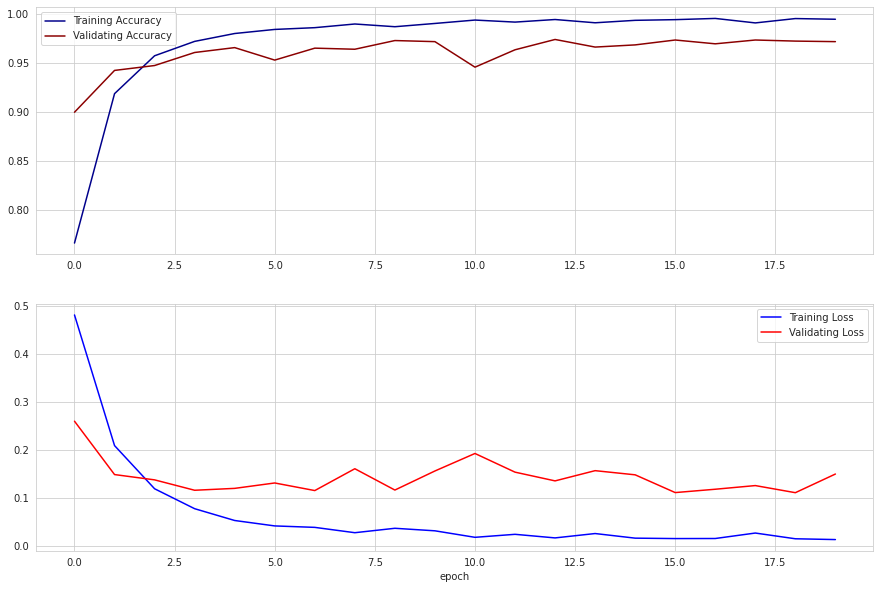

In [79]:
def plot_metrics(historial_train):
    plt.figure(figsize=(15, 10))

    acc = historial_train.history['accuracy']
    val_acc = historial_train.history['val_accuracy']
    loss = historial_train.history['loss']
    val_loss = historial_train.history['val_loss']

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(acc, color='darkblue', label='Training Accuracy')
    ax1.plot(val_acc, color='darkred', label='Validating Accuracy')
    ax1.legend()

    ax1 = plt.subplot(2, 1, 2)
    ax1.set_xlabel('epoch')
    ax1.plot(loss, color='blue', label='Training Loss')
    ax1.plot(val_loss, color='red', label='Validating Loss')
    ax1.legend()


plot_metrics(historial_train)

Model evaluation.

In [ ]:
loss_train, accuracy_train = keras_model.evaluate(X_train, y_train)
loss_test, accuracy_test = keras_model.evaluate(X_test, y_test)

#### Export

Save to file.

In [ ]:
h5_filename = f'{resources_prefix}_resources/keras_model.h5'
keras_model.save(h5_filename)

Load from file.

In [ ]:
keras_model = load_model(h5_filename)
keras_model